# Импорты

In [1]:
from datetime import date, datetime
from sklearn.utils import resample
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import pickle

# Функции

In [2]:
def cat_num_split(df: pd.DataFrame) -> tuple:
    '''Ищем категориальные и числовые признаки в датафрейме'''

    cat_columns = []
    num_columns = []

    for column_name in df.columns:
        if (df[column_name].dtypes == object):
            cat_columns += [column_name]
        else:
            num_columns += [column_name]

    print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))
    print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))

    return cat_columns, num_columns

In [3]:
def target_columns_dropper(df: pd.DataFrame) -> pd.DataFrame:
    '''Сбрасываем столбцы с целевыми переменными ответа банков'''
    df = df.copy()
    banks = ['BankA_decision',
             'BankB_decision',
             'BankC_decision',
             'BankD_decision',
             'BankE_decision']
    try:
        df.drop(banks, axis='columns', inplace=True)
    except:
        print('Dataframe have not target columns')

    return df

In [4]:
def CarierLevel_feature_creator_v2(df: pd.DataFrame) -> pd.Series:
    """
    Варианты преобразования:
    НИЗШЕЕ_ЗВЕНО     1809    рабочие специальности
    СРЕДНЕЕ_ЗВЕНО    1302    рядовые инженеры, врачи и специалисты с высшим образованием
    МЕН1              921    старшие менеджеры
    МЕН2              583    менеджеры
    ДИР1              242    генеральные директора и им подобные
    ДИР2              554    директора магазинов, направлений и им подобные
    САМ               521    самозанятые
    ИП                404    индивидуальные предприниматели
    ЗАМДИР            128    заместители директоров
    РЕЗЕРВ            109    те кто без работы
    ЗАМНАЧ             30
    """
    f = df['Position'].copy()
    f = f.str.lower()
    f = f.str.strip()
    f1 = f
    L_7 = [
    "генеральный директор",
    "генеральный дирекор",
    "генеральный",
    "гене",
    "генер",
    "генера",
    'генераль',
    "ген дир",
    "ген",
    "учредитель",
    'соучредитель',
    'собственник',
    'полномочный представитель президента',
    'председатель наблюдательского совета',
    'президент'
    ]
    for s in L_7:
       f1 = f1.mask(lambda  x : x == s, other = 'ДИР1')
    L_6 = [
    "директор",
    'директрор',
    "руководитель",
    "директор филиала/ департамента",
    'директор магазина',
    'дирек',
    'дирек',
    'дире',
    'дир',
    'председатель',
    'продюссер'
    ]
    for s in L_6:
       f1 = f1.mask(lambda  x : x == s, other = 'ДИР2')
    L_5 = [
    "заместитель директора",
    "заместитель генерального директора",
    'заместитель директора',
    "зам",
    "коммерческий директор",
    "заместитель / и.о. генерального директора",
    "и.о. заместитель ген. директора по развитию",
    "зам.руководителя",
    'зам.зав аптекой'
    ]
    for s in L_5:
       f1 = f1.mask(lambda  x : x == s, other = 'ЗАМДИР')
    L_4 = [
      "старший менеджер",
      "старший мене",
      "старший менедж",
      "ведущий менеджер",
      "главный менеджер",
      "главный специалист",
      'главный спе'
      "главный инженер",
      "менеджер",
      "мене",
      "менед",
      "руков",
      "руко",
      "рук",
      "главный бухгалтер",
      'главный бух',
      "начальник отдела",
      "начальник",
      "продюсер",
      "руководитель отдела",
      "менеджер по работе с ключевыми клиентами",
      "начальнык отдела",
      "начальник п",
      'менеджер по работе с маркетплейсами',
      'руководитель колл-центра',
      'начальник участка',
      'руководитель отдела продаж',
      'региональный менеджер',
      'директор по развитию',
      'заведующая отделением',
      'старший администратор',
      'главный технолог',
      'командир',
      'рукводитель',
      'шеф',
      'управляющий магазином',
      'старший мен',
     'старший тренер'
    ]
    for s in L_4:
       f1 = f1.mask(lambda  x : x == s, other = 'МЕН1')
    L_3 = [
     "администратор",
     "админи",
     "адм",
     "вдминистратор",
     'адми',
     "управляющий",
     "управляющая",
     'управ',
     "менеджер по продажам",
     "специалист по продажам",
     "менедж",
     'мэнеджер',
     'мннеджер',
     "мастер",
     "маст",
     "оператор склада",
     "менеджер по работе с маркетплейсами",
     'руководитель колл-центра', 'заведующий складом',
     'менеджер по закупкам','менеджер по закупке',
     'старший продавец',
     'менеджер торговой зоны',
     'старший сотрудник охраны',
     'командир отдедения',
     'командир отделения',
     'старший кладовщик',
     'старший продавец-консультант',
     'заведующий',
     'бригадир',
     'бриг',
     'админ',
     'организатор'
     'управляющий персоналом',
     'управляющий персоналом',
     'управляющий отделением',
     'заведующая производством',
     'главный библиотекарь',
     'старший инструктор',
     'кассир-контроллер',
     'старшая акушерка',
     'старший кассир',
     'администрато',
     'руководител',
     'главный мех',
     'управляющи',
     'старший ме',
     'шеф-повар',
     'управляющ',
     'управляю',
     'админист',
     'управля',
     'менедже',
     'директо',
     'админис',
     'управл',
     'руково',
     'завуч',
     'нача',
     'организатор перевозок',
     'заведующая складом',
     'старший капитан'
     ]
    for s in L_3:
       f1 = f1.mask(lambda  x : x == s, other = 'МЕН2')
    L_2 = [
   "старший специалист",
   "старший спец",
   "ведущий специалист",
   'ведущий спе',
   'логопед',
   'психолог',
   'воспит',
   'вос',
   'дизайнер',
   "товаровед",
   "маркетолог",
   'hr',
  'кадровый работник',
   "бухгалтер",
   'бухга',
   'бухг'
   "бух",
   'бух',
   "преподаватель",
   "препо",
   "учитель",
   "инженер",
   'инже',
   "инж",
   "оператор",
   "врач",
   "программист",
   "графический дизайнер",
   "репетитор",
   "технолог",
   "экономист",
   "юрист",
   "адвокат",
   "редседатель",
   "машинист",
   "хормейстер",
   "ведущий инженер",
   "старший слесарь",
   "системный администратор",
   "воспитатель",
   "эксперт",
   "доцент",
   "финансовый консультант",
   'фин',
   "аналитик",
   'средний медперсонал',
   'маркето',
   'режиссер',
   'режиссер',
   'музыкальный р',
   'кассир-контролер',
   'секретарь',
   'риэлтор',
   'риэ',
   'риелтор',
   'педагог',
   'пластический хирург',
   'логопед'
   "специалист",
   "спец",
   "специ",
   "specialist",
   'дизайнер',
   "копирайтер",
   "педагог до",
   'Учитель-логопед.',
   'учит',
   'учит',
   'учите',
   'учи',
   'юрисконсульт',
   'юридический консультант',
   'провизор',
   'коуч',
   'прог',
   'логист',
   'электроник /электронщик',
   'эксперт в сфере образования',
   'художник театрального костюма',
   'финансовый контроллер',
   'тренер групповых программ',
   'старший инжинер по разработке',
   'солист военного оркестра',
   'секретарь учебной части',
   'разработчик автоворонок',
   'педагог дополнительного образования',
   'мастер строительных работ',
   'мастер производственного обучения вождению',
   'агент по недвижимости',
   'финансовый советник',
   'младший воспитатель',
   'эксперт по рекламе',
   'управляющий делами',
   'социальный педагог',
   'машинист тепловоза',
   'днелопроизводитель',
   'старший товаровед',
   'профессор кафедры',
   'старший психолог',
   'культорганизатор',
   'химик-технолог',
   'мастер участка',
   'концертмейстер',
   'преподователь',
   'авиадиспетчер',
   'главный спец',
   'библиотекарь',
   'тестировщик',
   'старший тех',
   'старший спе',
   'старший инс',
   'следователь',
   'разработчик',
   'организатор',
   'нутрициолог',
   'главный спе',
   'таргетолог',
   'специолист',
   'метеоролог',
   'главный бу',
   'фрилансер',
   'сценарист',
   'специалст',
   'научный с',
   'маршейдер',
   'лешмейкер',
   'штурман',
   'фриланс',
   'препода',
   'подолог',
   'воспита',
   'специа',
   'релтор',
   'режисс',
   'препод',
   'логист',
   'инжене',
   'дизай',
   'воспи',
   'фарм',
   'медицинский психолог',
   'геолог',
   'кредитный эксперт'
    ]
    for s in L_2:
      f1 = f1.mask(lambda  x : x == s, other = 'СРЕДНЕЕ_ЗВЕНО')
    L_1 = [
     'лесной пожарный',
     'мастер бровист',
     'контролер кпп',
     'бьюти мастер',
     'мастер ман',
     'кровельщик',
     'Мед сестра',
     'астролог',
     'турагент',
     'аниматор',
     'волонтер',
     'массажист',
     'сушильщик',
     'рядовой',
     'самелье',
     'санитар',
     'медбрат',
     "уборщик",
     "сиделка",   
     "водитель",
     "продавец",
     "прода",
     "повар",
     "официант",
     "курьер",
     "консультант",
     "продавец-консультант",
     "продавец консультан",
     "продавец-кассир",
     "кладовщик",
     "косметолог",
     "сотрудник охраны",
     "слесарь",
     "сле",
     "кассир",
     "массажист",
     "электромонтер",
     "монтажник",
     "мастер маникюра",
     "электрик",
     "элек",
     "торговый представитель",
     "механик",
     "супервайзер",
     "инструктор",
     "персональный менеджер",
     "водитель-экспедитор",
     "водит",
     "продавец кассир",
     "рабочий",
     'сварщик',
     'свар',
     'агент',
     'диспетчер',
     'медицинская сестра',
     'медсестра',
     'токарь',
     "офи",
     'офици',
     'тренер',
     'владелец',
     'психолог-консультант',
     'помощник юриста',
     "швея",
     'шве',
     "парикмахер",
     "техник",
     'охранник',
     'охр',
     'няня',
     'косметолог-визажист',
     'сотрудник',
     'сотрудник склада',
     'кондитер',
     'фельдшер',
     'формовщик',
     'маляр',
     'проходчик',
     'техперсонал',
     'строитель',
     'клад',
     'наставник',
     'уборщица',
     'оптометрист',
     'пекарь',
     'официа',
     'контралер',
     'разнорабочая',
     'кладов',
     'комплектовщик',
     'термист',
     'бар',
     'бариста',
     'моряк',
     'стано',
     'сторож',
     'таксис',
     'грузчик',
     'пред'
     ]
    for s in L_1:
      f1 = f1.mask(lambda  x : x == s, other = 'НИЗШЕЕ_ЗВЕНО')
    f1 = f1.mask(lambda x : x == "индивидуальный предприниматель", other = 'ИП')
    f1 = f1.mask(lambda x : x == "индивидуальный пре", other = 'ИП')
    f1 = f1.mask(lambda x : x == "индивидуальный", other = 'ИП')
    f1 = f1.mask(lambda x : x == "инд", other = 'ИП')
    f1 = f1.mask(lambda x : x == "ип", other = 'ИП')
    f1 = f1.mask(lambda x : x == "индив", other = 'ИП')
    f1 = f1.mask(lambda x : x == "индиви", other = 'ИП')
    f1 = f1.mask(lambda x : x == "индивидуальны", other = 'ИП')
    f1 = f1.mask(lambda x : x == "инди", other = 'ИП')
    f1 = f1.mask(lambda x : x == "предприниматель", other = 'ИП')
    f1 = f1.mask(lambda x : x == "предпри", other = 'ИП')
    f1 = f1.mask(lambda x : x == "самозанятый", other = 'САМ')
    f1 = f1.mask(lambda x : x == "самозанятая", other = 'САМ')
    f1 = f1.mask(lambda x : x == "самоазанятый", other = 'САМ')
    f1=f1.fillna('НЕТ_ДАННЫХ')
    Filled = ['ДИР1','ДИР2', 'МЕН1', 'МЕН2','ИП','САМ',
              'ЗАМДИР','ЗАМНАЧ', 'НИЗШЕЕ_ЗВЕНО', 'СРЕДНЕЕ_ЗВЕНО', 'НЕТ_ДАННЫХ', "РЕЗЕРВ"]
    # Названия должностей которые входят в некоторую строку.
    f1[f1.str.contains('рабочий')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('слесарь')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('помощник')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('сборщик')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('руководитель')] = 'МЕН1'
    f1[f1.str.contains('начальник ')] = 'МЕН1'
    f1[f1.str.contains('самоз')] = 'САМ'
    f1[f1.str.contains('инспектор')] = 'СРЕДНЕЕ_ЗВЕНО'
    f1[f1.str.contains('инженер')] = 'СРЕДНЕЕ_ЗВЕНО'
    f1[f1.str.contains('врач')] = 'СРЕДНЕЕ_ЗВЕНО'
    f1[f1.str.contains('вра')] = 'СРЕДНЕЕ_ЗВЕНО'
    f1[f1.str.contains('фармацевт')] = 'СРЕДНЕЕ_ЗВЕНО'
    f1[f1.str.contains('старший специалист')] = 'СРЕДНЕЕ_ЗВЕНО'
    f1[f1.str.contains('представитель')] = 'СРЕДНЕЕ_ЗВЕНО'
    f1[f1.str.contains('преподаватель')] = 'СРЕДНЕЕ_ЗВЕНО'
    f1[f1.str.contains('ведущий')] = 'СРЕДНЕЕ_ЗВЕНО'
    f1[f1.str.contains('бухг')] = 'СРЕДНЕЕ_ЗВЕНО'
    f1[f1.str.contains('учитель')] = 'СРЕДНЕЕ_ЗВЕНО'
    f1[f1.str.contains('заместитель директора')] = 'ЗАМДИР'
    f1[f1.str.contains('заместитель')] = 'ЗАМНАЧ'
    f1[f1.str.contains('заме')] = 'ЗАМНАЧ'
    f1[f1.str.contains('оператор')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('лаборант')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('электрик')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('продавец')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('сварщик')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('менеджер')] = 'МЕН2'
    f1[f1.str.contains('главный специалист')] = 'МЕН2'
    f1[f1.str.contains('специалист')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('монтажник')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('водитель ')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('парикмахер')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('ногтевого')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('санитарка')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('продав')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('монтер')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('техник')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('продовец')] = 'НИЗШЕЕ_ЗВЕНО'
    f1[f1.str.contains('директор')] = 'ДИР2'
    f1[f1.str.contains('безработный')] = 'РЕЗЕРВ'
    #f1 = f1[~f1.isin(Filled)] # Временно убираем обработанные строки.
    f1[~f1.isin(Filled)] = 'НИЗШЕЕ_ЗВЕНО'
    #print(contain_values)
    CarierLevel = f1

    return CarierLevel


def features_creator_pipe(df: pd.DataFrame) -> pd.DataFrame:
   '''Пайплайн  создания признаков, необходимых для работы модели'''
   df = df.copy()

   return df

In [5]:
def create_cat_pool(
        df: pd.DataFrame, 
        feature_name: str
        ) -> tuple:
    '''Создаем тренировочный и валидационный набор для CatBoost'''
    df = df.copy()
    y = df[feature_name]
    df = target_columns_dropper(df)
    X = df
    features_names = list(X.columns)
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=42)
    cat_features, num_features = cat_num_split(X)
    train_data = Pool(
        data=X_train, 
        label=y_train,
        cat_features=cat_features,
        feature_names=features_names
    )
    eval_data = Pool(
        data=X_test,
        label=y_test,
        cat_features=cat_features,
        feature_names=features_names
    )

    return train_data, eval_data, features_names

In [6]:
def create_cls_model(
        train_data,
        eval_data,
        features_names
        ) -> CatBoostClassifier:
    '''Создаем модель классификатора CatBoost'''
    model = CatBoostClassifier(task_type="GPU", iterations=10000, early_stopping_rounds=100)
    model.fit(X=train_data, eval_set=eval_data)

    ftr_imp = model.feature_importances_/np.sum(model.feature_importances_)
    sorted = np.argsort(ftr_imp)
    ypos = np.arange(len(np.array(features_names)))
    fig = plt.figure(figsize=(8, 8))
    plt.barh(ypos, ftr_imp[sorted])
    plt.xlim([0, 1])
    plt.title('Распределение весов входных параметров')
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos, np.array(features_names)[sorted]);
    plt.show()

    return model

In [7]:

def Age_feature_creator(
    df: pd.DataFrame,
    ) -> pd.Series:
    '''Создаем признак "возраст"'''
    df = df.copy()

    return date.today().year - df['BirthDate'].dt.year


def Num_value_feature_creator(
    df: pd.DataFrame,
    ) -> pd.Series:
    '''Создаем признак "стаж работы" из даты начала работы'''
    df = df.copy()

    return date.today().year - df['JobStartDate'].dt.year


def Monthly_credit_payment(
    df: pd.DataFrame,
    ) -> pd.Series:
    '''Создаем функцию расчета ежемесячного платёжа'''
    df = df.copy()

    return df['Loan_amount'] // df['Loan_term']


def Payment_to_income(
    df: pd.DataFrame,
    ) -> pd.Series:
    '''Создаем признак "показатель долговой нагрузки"'''
    df = df.copy()
    monthly_payment = Monthly_credit_payment(df) + df['MonthExpense']

    return monthly_payment / df['MonthProfit']

In [8]:
def upsampling_data(
        df: pd.DataFrame,
        target_column_name: str
        ) -> pd.DataFrame:
    '''Балансируем классы в выборке через upsampling'''

    success = df[df[target_column_name]=="success"]
    denied = df[df[target_column_name]=="denied"]
    df_upsample = resample(denied,
                           replace=True,
                           n_samples=len(success),
                           random_state=42)
    
    return pd.concat([success, df_upsample])

In [10]:
def upsampling_data(
        df: pd.DataFrame,
        balanced_feature_name: str
        ) -> pd.DataFrame:
    '''Делаем балансировку классов в выборке через upsampling'''
    success = df[df[balanced_feature_name] == 'success']
    denied = df[df[balanced_feature_name] == 'denied']
    denied_upsample = resample(denied,
                               replace=True,
                               n_samples=len(success),
                               random_state=42)
    
    return pd.concat([success, denied_upsample])

# Загружаем датасет

In [11]:
# Подгружаем чищеный датасет и делаем препроцессинг
df = pd.read_csv(
    filepath_or_buffer='../data/cleared_df.csv',
    sep=';',
    index_col='SkillFactory_Id',
    parse_dates=['BirthDate', 'JobStartDate']
    )
df = df[(df['BankA_decision'] != 'error') &
        (df['BankB_decision'] != 'error') &
        (df['BankC_decision'] != 'error') &
        (df['BankD_decision'] != 'error') &
        (df['BankE_decision'] != 'error')]
df['Position'] = CarierLevel_feature_creator_v2(df)
df['Age'] = Age_feature_creator(df)
df.drop(['BirthDate'], axis='columns', inplace=True)
df['NumValue'] = Num_value_feature_creator(df)
df.drop(['JobStartDate', 'Value'], axis='columns', inplace=True)
df['Payment_to_income'] = Payment_to_income(df)
df.drop(['MonthProfit', 'MonthExpense', 'Loan_amount', 'Loan_term'],
        axis='columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6253 entries, 1.0 to 8787.0
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   education          6253 non-null   object 
 1   employment status  6253 non-null   object 
 2   Position           6253 non-null   object 
 3   Gender             6253 non-null   float64
 4   Family status      6253 non-null   object 
 5   ChildCount         6253 non-null   float64
 6   SNILS              6253 non-null   float64
 7   BankA_decision     6253 non-null   object 
 8   BankB_decision     6253 non-null   object 
 9   BankC_decision     6253 non-null   object 
 10  BankD_decision     6253 non-null   object 
 11  BankE_decision     6253 non-null   object 
 12  Merch_code         6253 non-null   float64
 13  Goods_category     6253 non-null   object 
 14  Age                6253 non-null   int32  
 15  NumValue           6253 non-null   int32  
 16  Payment_to_income  6253 n

In [12]:
# Здесь мы отрезаем кусочек от исходного датасета для проверки качества модели.
# Ни для обучения, ни для валидации в процессе обучения его не используем,
# он нужен для проверки качества работы модели в самом конце.
X = df
y = df['BankA_decision']
X_train, X_test, _, _ = train_test_split(X,
                                         y,
                                         test_size=0.2,
                                         random_state=42)
X_test.to_csv('../data/model_val.csv', sep=';', index=True)
df = X_train

3792 1210


<Axes: ylabel='Type'>

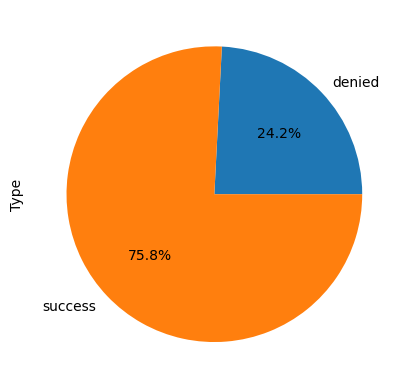

In [13]:
# Смотрю баланс классов в выборке
sucess = df[df['BankA_decision'] == 'success'].shape[0]
denied = df[df['BankA_decision'] == 'denied'].shape[0]
print(sucess, denied)
# Вывод - выборка не сбалансированная, надо балансить
df.groupby('BankA_decision').size().plot(kind='pie',
                                        y = "BankA_decision",
                                        label = "Type",
                                        autopct='%1.1f%%')

# Создаем файлы моделей

(5002, 17)
(7616, 17)
categorical columns:	  ['education', 'employment status', 'Position', 'Family status', 'Goods_category'] 
 len =  5
numerical columns:	  ['Gender', 'ChildCount', 'SNILS', 'Merch_code', 'Age', 'NumValue', 'Payment_to_income'] 
 len =  7
Learning rate set to 0.023541
0:	learn: 0.6926120	test: 0.6928765	best: 0.6928765 (0)	total: 34.7ms	remaining: 5m 46s
1:	learn: 0.6920293	test: 0.6926250	best: 0.6926250 (1)	total: 65.3ms	remaining: 5m 26s
2:	learn: 0.6913457	test: 0.6921975	best: 0.6921975 (2)	total: 98ms	remaining: 5m 26s
3:	learn: 0.6911163	test: 0.6920882	best: 0.6920882 (3)	total: 132ms	remaining: 5m 30s
4:	learn: 0.6908168	test: 0.6919794	best: 0.6919794 (4)	total: 167ms	remaining: 5m 33s
5:	learn: 0.6898077	test: 0.6909973	best: 0.6909973 (5)	total: 200ms	remaining: 5m 33s
6:	learn: 0.6895219	test: 0.6909647	best: 0.6909647 (6)	total: 233ms	remaining: 5m 31s
7:	learn: 0.6889676	test: 0.6906900	best: 0.6906900 (7)	total: 266ms	remaining: 5m 32s
8:	learn: 0.688

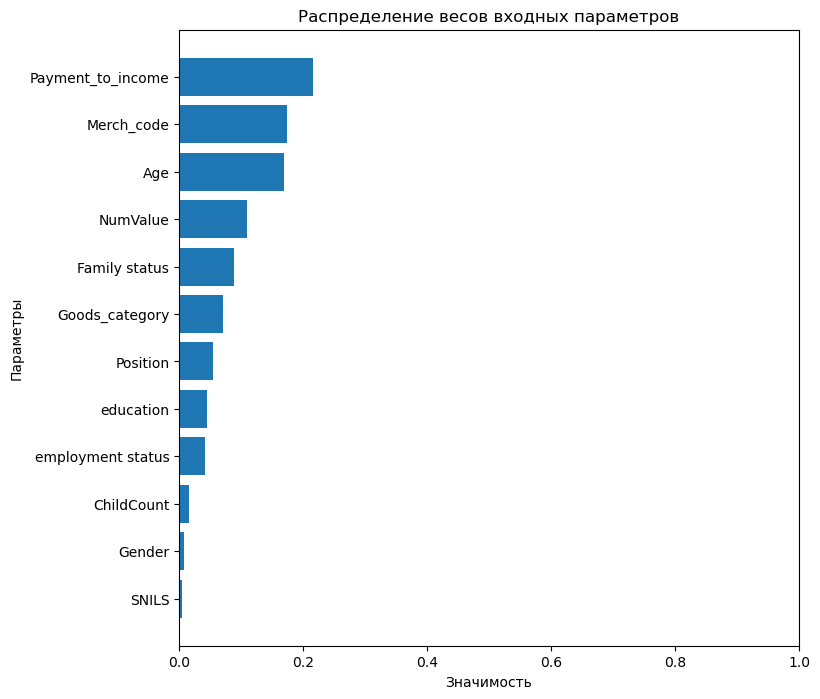

In [18]:
BankLabel = 'BankE_decision'
# Готовим Pool для обучения модели на алгоритме CatBoost:
fd = df.copy()
# Делаем upsampling для соответствующей целевой переменной
print(fd.shape)
fd = upsampling_data(fd, BankLabel)
print(fd.shape)
train_data, eval_data, features_names = create_cat_pool(fd, BankLabel)
# Обучаем модель
model = create_cls_model(train_data, eval_data, features_names)
#model.save_model('../models/BankA_decision.cls')
pickle.dump(model, open(f'../models/{BankLabel}.cls', 'wb'))